In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

import kelp_compute

sp.init_printing()
%matplotlib inline

from fortran_wrappers.pykelp3d_wrap import pykelp3d_wrap as f90
f90.solve_rte_with_callbacks?

In [3]:
space = sp.var('x, y, z')
x, y, z = space
vec_x = sp.Matrix(space)

angle = sp.var(r'theta, phi')
th, ph = angle
vec_om = sp.Matrix([sp.sin(ph)*sp.cos(th), sp.sin(ph)*sp.sin(th), sp.cos(ph)])
delta = sp.var(r'Delta')

angle_prime = sp.var(r'theta_p, phi_p')
thp, php = angle_prime
vec_omp = sp.Matrix([sp.sin(php)*sp.cos(thp), sp.sin(php)*sp.sin(thp), sp.cos(php)])

In [4]:
def grad(expr, space=space):
    return sp.Matrix([sp.diff(expr, d) for d in space])

In [5]:
def sphere_integral(expr, angle):
    theta, phi = angle
    return sp.integrate(expr*sp.sin(phi), (theta, 0, 2*sp.pi), (phi, 0, sp.pi))

In [6]:
def dot(a, b):
    return sum(a.T * b)

In [7]:
def gen_grid(ns, nz, na, rope_spacing, zmax):
    ds = rope_spacing/ns
    dz = zmax/nz
    
    x = y = -rope_spacing/2 + ds * (np.arange(ns) + 1/2)
    z = dz * (np.arange(nz) + 1/2)
    
    ntheta = nphi = na
    nomega = ntheta*(nphi-2) + 2
    
    dtheta = 2*np.pi/ntheta
    dphi = np.pi/(nphi-1)
    
    theta = dtheta * np.arange(ntheta)
    phi = dphi * np.arange(nphi)

    l = np.arange(ntheta)
    m = np.arange(nphi)
    p = np.arange(nomega)

    L, M = np.meshgrid(l, m, indexing='ij')
    
    phat = (M-1)*ntheta + L + 1
    phat[:,0] = 0
    phat[:,-1] = nomega-1
    
    theta_p = np.zeros(nomega)
    phi_p = np.zeros(nomega)
    theta_p[phat] = theta[L]
    theta_p[0] = theta_p[-1] = 0
    phi_p[phat] = phi[M]
    
    # A bit redundant, but seems to work
    X, Y, Z, Theta = np.meshgrid(x, y, z, theta_p, indexing='ij')
    _, _, _, Phi = np.meshgrid(x, y, z, phi_p, indexing='ij')
    
    return X, Y, Z, Theta, Phi

---

In [8]:
def calculate_source(L, b, a, beta, params=()):
    L_om = L(*space, *angle, *params)
    L_omp = L(*space, *angle_prime, *params)
    
    deriv = dot(vec_om, grad(L_om))
    atten = (a(*space)+b)*L_om
    
    scat_integrand = dot(vec_om, grad(L_omp))
    scat = sphere_integral(scat_integrand, angle=angle_prime)
    
    source = deriv + atten - scat
    
    return source

In [9]:
def calculate_bc(L, params=()):
    z = space[-1]
    zmin = 0
    return L(*space, *angle, *params).subs(z, zmin)

In [10]:
b = sp.var('b')
params = sp.var('alpha, gamma')

In [64]:
def uniform_vsf(delta):
    return 1/(4*sp.pi) + 0*delta

In [48]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(2*sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        *(2+sp.sin(phi))
    )

In [49]:
# TODO: Should be periodic on correct grid
def prod_a(x, y, z):
    return (2+sp.sin(2*sp.pi*x))*(2+sp.sin(2*sp.pi*y))*(1+sp.tanh(z-gamma))

In [50]:
def uniform_a(x, y, z):
    return 1

In [51]:
prod_source = calculate_source(prod_L, b, uniform_a, uniform_vsf, params)
prod_bc = calculate_bc(prod_L, params)

In [66]:
alpha = 1
gamma = 1
b = 0.0

In [83]:
prod_source_sym = sp.lambdify(
    (*space, *angle), 
    prod_source.subs('alpha', alpha).subs('gamma', gamma).subs('b', b),
    modules=("sympy",)
)

prod_a_sym = sp.lambdify(
    space,
    prod_a(*space),
    modules=("sympy",)
)

prod_bc_sym = sp.lambdify(
    angle, 
    prod_bc.subs('alpha', alpha).subs('gamma', gamma),
    modules=("sympy",)
)

uniform_vsf_sym = uniform_vsf
# uniform_vsf_sym = sp.lambdify(
#     (delta,), 
#     uniform_vsf(delta),
#     modules=("sympy",)
# )

sol_func_sym = sp.lambdify(
    (*space, *angle), 
    prod_L(*space, *angle, *params).subs('alpha', alpha).subs('gamma', gamma).subs('b', b),
    modules=("sympy",)
)

In [84]:
abs_func = prod_a_sym
source_func = prod_source_sym
bc_func = prod_bc_sym
vsf_func = uniform_vsf_sym

In [85]:
# Convert callbacks to numpy functions
abs_func_N = sp.lambdify(
    space,
    abs_func(*space),
    modules=("numpy",)
)

source_func_N = sp.lambdify(
    (*space, *angle),
    source_func(*space, *angle),
    modules=("numpy",)
)

bc_func_N = sp.lambdify(
    angle,
    bc_func(*angle),
    modules=("numpy",)
)

vsf_func_N = vsf_func
# vsf_func_N = sp.lambdify(
#     (delta,),
#     vsf_func(delta),
#     modules=("numpy",)
# )

# Do the same for manufactured solution
sol_func_N =sp.lambdify(
    (*space, *angle),
    sol_func_sym(*space, *angle),
    modules=("numpy",)
)

In [91]:
vsf_func(np.array([1,2]))

array([1/(4*pi), 1/(4*pi)], dtype=object)

In [92]:
def vsf_wrapper(*args):
    print("got args: {}".format(args))
    ans = vsf_func(*args)
    print("ans: {}".format(ans))
    return ans

In [96]:
ns = 10
nz = 10
na = 10
nomega = na*(na-2) + 2
rope_spacing = 1
zmax = 1

lis_opts = "-i gmres"
fd_flag = False
num_scatters = 0

scalar_params, results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_func, source_func, bc_func, vsf_func,
    num_scatters, fd_flag, lis_opts
)

In [97]:
x, y, z, theta, phi = gen_grid(ns, nz, na, rope_spacing, zmax)

In [98]:
x1 = x[:,0,0,0].reshape(ns,1,1,1)
y1 = y[0,:,0,0].reshape(1,ns,1,1)
z1 = z[0,0,:,0].reshape(1,1,nz,1)
t1 = theta[0,0,0,:].reshape(1,1,1,nomega)
p1 = phi[0,0,0,:].reshape(1,1,1,nomega)

In [103]:
true_sol = sol_func_N(x, y, z, theta, phi)
asymptotic_sol = results['rad']

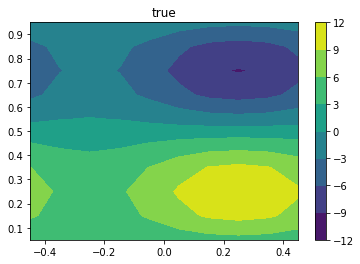

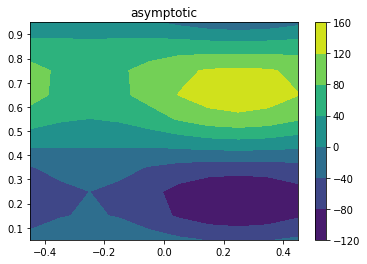

In [108]:
plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], true_sol[:,0,:,0])
plt.colorbar()
plt.title('true')

plt.figure()
plt.contourf(x[:,0,:,0], z[:,0,:,0], asymptotic_sol[:,0,:,0])
plt.colorbar()
plt.title('asymptotic')
plt.show()